<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/ADI/20210209_LSTM%20MonteCarlo%20AirPassengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
%tensorflow_version 1.x
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import os

TensorFlow 1.x selected.


### Importar a base de dados

In [3]:
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

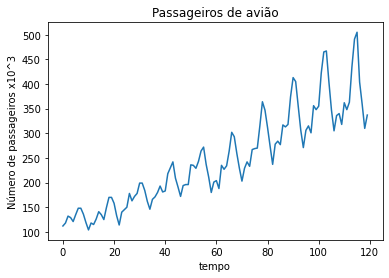

In [4]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("Número de passageiros x10^3")
plt.title("Passageiros de avião")
plt.show()

### Normalização

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [6]:
window = 10
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [7]:
X_train.shape

(110, 10)

Shape de input da lstm = (batch_size, timesteps, features)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
X_train.shape

(110, 10, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Construção da Rede completa

In [11]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            57920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_______________________________________

### Treinamento

In [12]:
history = regressor.fit(X_train, y_train, epochs = 500, batch_size = 32)


Epoch 1/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1372
Epoch 2/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 3/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 4/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 5/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0346
Epoch 6/500
110/110 [==============================] - 0s 1000us/step - loss: 0.0245
Epoch 7/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 8/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 9/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 10/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 11/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 12/500
110/110 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 13

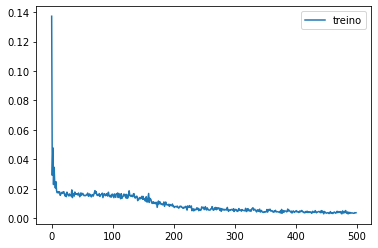

In [13]:
plt.plot(history.history['loss'], label='treino')
plt.legend();

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [15]:
dataset_test = pd.read_csv('test.csv')
test_airline = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [16]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [17]:
predicted_airline = regressor.predict(X_test)
predicted_airline = sc.inverse_transform(predicted_airline)

### Visualizar os resultados de treino e teste

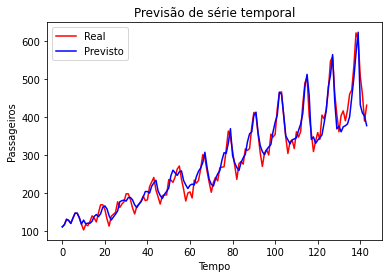

In [18]:
allTargetData = np.vstack((training_set, test_airline))
training_predicted_airline = regressor.predict(X_train)
training_predicted_airline = sc.inverse_transform(training_predicted_airline)
allForecastedData = np.vstack((training_set[0:window], training_predicted_airline, predicted_airline))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [19]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_airline, predicted_airline))
print('RMSE: ', rmse)

RMSE:  35.97663795755671


In [20]:
mse = mean_squared_error(test_airline, predicted_airline)
print('MSE: ',mse)

MSE:  1294.3184787291102


In [21]:
mape = np.mean(np.abs((test_airline - predicted_airline) / test_airline)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.611277776325442 %


In [22]:
from sklearn.metrics import r2_score
print('R2: ', r2_score(predicted_airline, test_airline))

R2:  0.7730244248393583


## Parte 5 - Aplicar Monte Carlo em geração de cenários

In [23]:
!pip install pandas-montecarlo

  Created wheel for pandas-montecarlo: filename=pandas_montecarlo-0.0.2-cp36-none-any.whl size=7554 sha256=8030f43b2a76dbfeeaced27435f47f54cdf8fca96e2d79f9c422de3e0e4db73b
  Stored in directory: /root/.cache/pip/wheels/8c/29/44/622bf8ea542ec73a0901a765b9102dd49f9e1076be3efc5411
Successfully built pandas-montecarlo


In [24]:
training_set[:5]

array([[112],
       [118],
       [132],
       [129],
       [121]])

In [26]:
len(test_airline)

24

In [27]:
import pandas_montecarlo

n_experimentos = 9
mc_x1 = pd.DataFrame(test_airline)[0].montecarlo(sims=n_experimentos+1)
mc_x1.data

,original,1,2,3,4,5,6,7,8,9
0,360,535,407,342,535,391,391,396,559,417
1,342,420,432,419,362,360,432,406,606,405
2,406,508,461,362,419,548,461,417,508,420
3,396,472,548,548,472,472,396,360,472,463
4,420,606,417,396,407,461,390,405,622,406
5,472,461,406,463,390,463,461,472,391,461
6,548,432,390,508,606,342,606,390,432,622
7,559,390,472,390,396,406,342,461,463,472
8,463,406,461,391,461,535,622,548,396,432
9,407,472,396,606,406,419,360,622,472,407


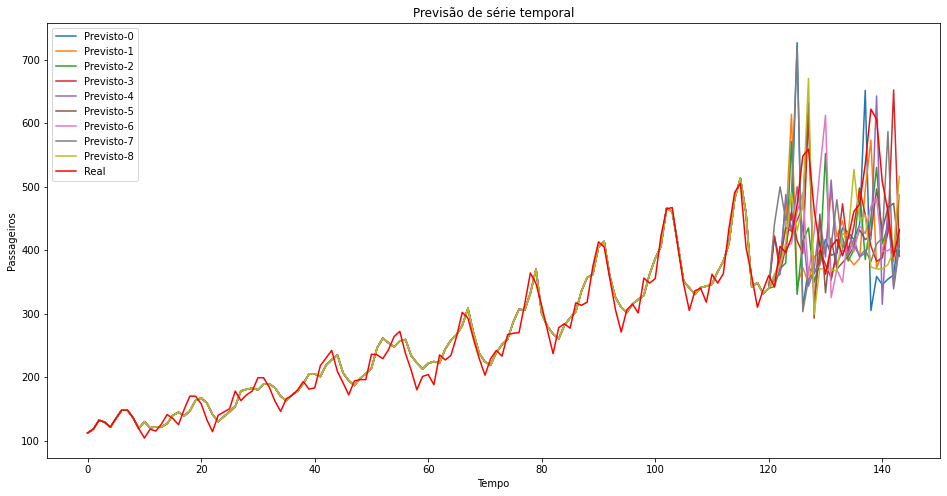

In [28]:
plt.figure(figsize=(16,8))
complete_dataset_cenarios = []
for i in range(n_experimentos):
  dataset_total = pd.concat((dataset_train.iloc[:,1], mc_x1.data[i+1]), axis = 0)
  complete_dataset_cenarios.append(dataset_total)
  testLength = len(mc_x1.data[i+1])
  inputs = dataset_total[len(dataset_total) - testLength - window:].values
  inputs = inputs.reshape(inputs.shape[0],1)

  inputs = sc.transform(inputs)
  X_test = []
  for j in range(window, inputs.shape[0]): 
      X_test.append(inputs[j-window:j, 0])
  X_test = np.array(X_test)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  predicted_airline = regressor.predict(X_test)
  predicted_airline = sc.inverse_transform(predicted_airline)

  # Preparação gráfica
  training_predicted_airline = regressor.predict(X_train)
  training_predicted_airline = sc.inverse_transform(training_predicted_airline)
  allForecastedData = np.vstack((training_set[0:window], training_predicted_airline, predicted_airline))
  plt.plot(allForecastedData, label = 'Previsto-'+str(i))

allTargetData = np.vstack((training_set, test_airline))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

### Agora tentem vocês...
Façam a mesma análise através da biblioteca de MC utilizando os valores dos últimos 24 meses da base de TREINO (e não da base de teste como foi utilizado).

#### Solução

In [29]:
x_train_last24 = training_set[-24:]

In [30]:
import pandas_montecarlo

n_experimentos = 30
mc_x1 = pd.DataFrame(x_train_last24)[0].montecarlo(sims=n_experimentos+1)
mc_x1.data

,original,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,315,467,305,315,359,435,305,340,404,467,422,318,465,301,336,315,347,348,318,363,318,404,491,348,465,467,422,305,315,356,362
1,301,305,404,347,336,359,355,422,301,310,337,315,337,356,347,363,355,363,465,491,348,305,467,310,505,359,340,301,355,467,340
2,356,505,348,305,315,362,435,315,348,318,404,305,318,404,305,359,337,305,435,404,359,363,315,491,491,491,336,359,359,340,355
3,348,340,362,348,355,301,467,404,355,301,491,505,491,422,340,336,505,465,347,422,356,505,404,505,310,362,355,505,347,348,465
4,355,356,301,348,348,337,363,301,348,305,359,404,505,310,315,337,465,336,355,318,465,435,362,359,356,356,467,404,363,315,363
5,422,337,404,301,318,340,362,363,318,347,336,491,315,505,301,422,359,337,301,348,347,422,318,404,301,404,356,348,435,359,318
6,465,347,310,363,422,505,465,310,505,340,348,404,347,340,355,355,301,318,340,362,348,318,404,362,348,505,347,491,318,404,310
7,467,404,491,465,404,404,422,491,305,336,348,355,355,336,310,465,315,467,359,355,336,362,435,318,404,315,435,356,301,301,315
8,404,359,336,310,356,315,356,362,356,315,404,336,305,435,465,404,362,491,404,465,362,355,359,465,359,355,465,348,337,318,467
9,347,348,337,404,301,404,301,336,362,359,347,301,435,305,422,348,348,348,336,301,435,467,336,347,347,465,310,337,465,505,359


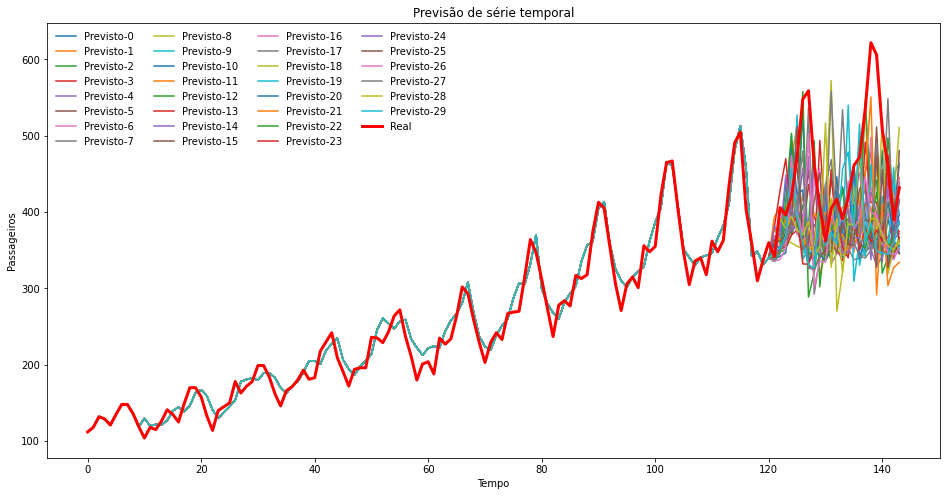

In [31]:
plt.figure(figsize=(16,8))
complete_dataset_cenarios = []
for i in range(n_experimentos):
  dataset_total = pd.concat((dataset_train.iloc[:,1], mc_x1.data[i+1]), axis = 0)
  complete_dataset_cenarios.append(dataset_total)
  testLength = len(mc_x1.data[i+1])
  inputs = dataset_total[len(dataset_total) - testLength - window:].values
  inputs = inputs.reshape(inputs.shape[0],1)

  inputs = sc.transform(inputs)
  X_test = []
  for j in range(window, inputs.shape[0]): 
      X_test.append(inputs[j-window:j, 0])
  X_test = np.array(X_test)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  predicted_airline = regressor.predict(X_test)
  predicted_airline = sc.inverse_transform(predicted_airline)

  # Preparação gráfica
  training_predicted_airline = regressor.predict(X_train)
  training_predicted_airline = sc.inverse_transform(training_predicted_airline)
  allForecastedData = np.vstack((training_set[0:window], training_predicted_airline, predicted_airline))
  plt.plot(allForecastedData, label = 'Previsto-'+str(i))

allTargetData = np.vstack((training_set, test_airline))
plt.plot(allTargetData, color = 'red', label = 'Real', linewidth=3)
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend(loc='upper left',frameon=False, ncol=4)
plt.savefig('predictions_training_test.svg')
plt.show()